# U.S. Inaugural data

1. What is the "name" of the dataset?

    Answer: U.S. Inaugural data


2. Where did you obtain it?

    The inaugural speech transcription can be donwnloaded everywhere in the internet. I obtain them from NLTK corpors library.

3. Where can we obtain it? (i.e., URL)

    https://avalon.law.yale.edu/subject_menus/inaug.asp

4. What is the license of the dataset? What are we allowed to do with it?

    Inaugural data does not have a specific license. They are also included and can be donwnloaded from the white house website. People can do whatever they want for it.

5. How big is it in file size and in items?

    There are 58 docs, 900kb in total (until Trump 2017).
    

6. Make a simple plot showing a relationship of interest. You can use matplotlib or pandas (or other). Don't worry about colors, labels or anything else of that nature!

    I plot the sentence number and sentence/doc in line chart; "america,democracy,freedom,protection" word frequency divided by the total words in bar chart.



In [26]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import Counter

from nltk.corpus import inaugural
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist

lemmatizer = WordNetLemmatizer()

%matplotlib inline

In [27]:
nltk.download('stopwords')
nltk.download('inaugural')
nltk.download('wordnet')

STOP = stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/ran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package inaugural to /home/ran/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
def get_pres_id():
    pres_list = inaugural.fileids()
    # name_set = set()
    last_name = None
    result = []
    for line in pres_list:
        year, n = line.rstrip(".txt").split("-")
        if n == last_name:
            last_name = n
            continue
        else:
            last_name = n
            result.append((year, n, line))
    return result

In [29]:
len(inaugural.fileids())

58

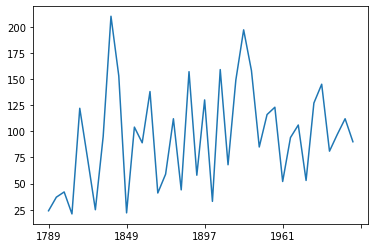

The longest speech is from Harrison, in 1841, containing 210 sentences.
The shortest speech is from Madison, in 1809, containing 21 sentences.


In [30]:
def count_sentence(ids):
    x = []
    y = []
    for year, name, fileid in ids:
        x.append(year)
        sent_cnt = len(inaugural.sents(fileid))
        y.append(sent_cnt)
    return x, y
ids = get_pres_id()
x, y = count_sentence(ids)
# print(len(x))
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.plot(x, y)
plt.show()

max_id = np.array(y).argmax()
min_id = np.array(y).argmin()
print("The longest speech is from %s, in %s, containing %d sentences." % (ids[max_id][1], ids[max_id][0], y[max_id]))
print("The shortest speech is from %s, in %s, containing %d sentences." % (ids[min_id][1], ids[min_id][0], y[min_id]))

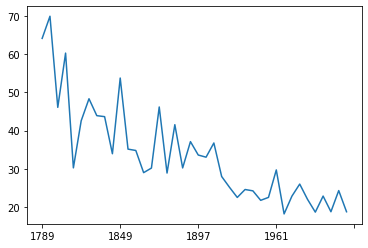

The longest average sentence is from Adams, in 1797, 69 words/sentence.
The shortest average sentence is from Johnson, in 1965, 18 words/sentence.


In [31]:
def count_avg_sent(ids):
    x = []
    y = []
    for year, name, fileid in ids:
        x.append(year)
        sent = inaugural.sents(fileid)
        lens = np.array([len(s) for s in sent]).mean()
        y.append(lens)
    return x, y
ids = get_pres_id()
x, y = count_avg_sent(ids)
# print(len(x))
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.plot(x, y)
plt.show()

max_id = np.array(y).argmax()
min_id = np.array(y).argmin()
print("The longest average sentence is from %s, in %s, %d words/sentence." % (ids[max_id][1], ids[max_id][0], y[max_id]))
print("The shortest average sentence is from %s, in %s, %d words/sentence." % (ids[min_id][1], ids[min_id][0], y[min_id]))

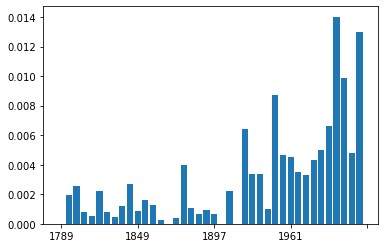

In [32]:
def keywords(ids):
    x = []
    y = []
    keyw = 'america,democracy,freedom,protection'.split(',')
    for year, name, fileid in ids:
        
        words = [lemmatizer.lemmatize(w.lower()) for w in inaugural.words(fileid) if w.isalnum()]
        ctr = Counter(words)
        
        cnt = sum([ctr[i] for i in keyw])
        all_words = len(inaugural.words(fileid))
        ratio = cnt/all_words
        
        x.append(year)
        y.append(ratio)
    return x, y
ids = get_pres_id()
x, y = keywords(ids)
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.bar(x, y)
plt.show()